# Crypto Clustering

**Mục tiêu:** Phân cụm mã crypto dựa trên **hành vi thống kê**
từ dữ liệu dạng **panel time-series không đều**.

**Pipeline:**
1. Nạp dữ liệu đã tiền xử lý (`processed_cryptotocurrency.csv`), chuẩn hóa `timestamp`.
2. Thống kê chất lượng chuỗi cho mỗi `symbol` (số điểm, độ phủ, khoảng cách thời gian).
3. Lọc các mã có chuỗi đủ dài/dày để đặc trưng ổn định.
4. Tạo vector đặc trưng cho từng `symbol` (price/return/volume/marketcap + skew/kurtosis + autocorr).
5. Chuẩn hóa, giảm chiều bằng PCA; chọn số cụm bằng silhouette score.
6. Phân cụm (KMeans), trực quan hóa và mô tả cụm.

## 1) Import thư viện & thiết lập chung

In [107]:
# Crypto clustering - cleaned & fixed version
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
# seaborn optional for nicer plots
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import iqr, zscore
import warnings
warnings.filterwarnings('ignore')


print("Libraries imported.")

Libraries imported.


## 2) Nạp dữ liệu & chuẩn hóa thời gian

In [108]:
DATA_PATH = 'processed_cryptotocurrency.csv'
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp']).sort_values(['symbol','timestamp']).reset_index(drop=True)

In [109]:
# -----------------------
# Load & normalize timestamps
# -----------------------
DATA_PATH = 'processed_cryptotocurrency.csv'
df = pd.read_csv(DATA_PATH)

# parse times robustly (dayfirst=True if your data uses that)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp']).sort_values(['name_encoded','timestamp']).reset_index(drop=True)

print("=== THÔNG TIN DỮ LIỆU ĐÃ TIỀN XỬ LÝ ===")
print("Shape:", df.shape)
print(df.dtypes)
print(f"Range: {df['timestamp'].min()} -> {df['timestamp'].max()}")
print("Unique name_encoded:", df['name_encoded'].nunique())

crypto_info = df.groupby('name_encoded').agg({
    'name': 'first',
    'symbol': 'first',
    'timestamp': ['count', 'min', 'max']
})
crypto_info.columns = ['name', 'symbol', 'count', 'first_obs', 'last_obs']
crypto_info['duration_days'] = (crypto_info['last_obs'] - crypto_info['first_obs']).dt.days
print("\nTop 10 by count:")
print(crypto_info.sort_values('count', ascending=False).head(10))

=== THÔNG TIN DỮ LIỆU ĐÃ TIỀN XỬ LÝ ===
Shape: (170430, 10)
timestamp       datetime64[ns]
name                    object
symbol                  object
price_usd              float64
vol_24h                float64
total_vol              float64
chg_24h                float64
chg_7d                 float64
market_cap             float64
name_encoded             int64
dtype: object
Range: 2025-01-04 00:34:00 -> 2025-12-10 23:52:00
Unique name_encoded: 266

Top 10 by count:
                   name symbol  count           first_obs            last_obs  \
name_encoded                                                                    
226                USDC   USDC   6319 2025-01-04 00:34:00 2025-12-10 23:52:00   
187              Solana    SOL   6319 2025-01-04 00:34:00 2025-12-10 23:52:00   
199             Stellar    XLM   6318 2025-01-04 00:34:00 2025-12-10 23:52:00   
253                 XRP    XRP   6318 2025-01-04 00:34:00 2025-12-10 23:52:00   
66             Dogecoin   DOGE   6317

## 3) Đánh giá chất lượng chuỗi theo từng mã


=== ĐÁNH GIÁ CHẤT LƯỢNG CHUỖI ===
Sample quality stats:
   name_encoded  n_obs  span_days  data_density  cv_interval  quality_score  \
0             0      6        0.0           0.0          NaN            0.0   
1             1      6        0.0           0.0          NaN            0.0   
2             2      6        0.0           0.0          NaN            0.0   
3             3      6        0.0           0.0          NaN            0.0   
4             4      6        0.0           0.0          NaN            0.0   

   is_usable  
0      False  
1      False  
2      False  
3      False  
4      False  


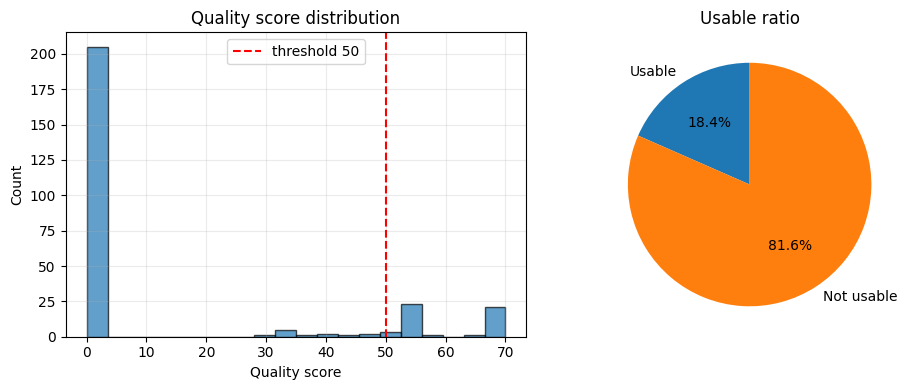

Usable: 49/266 (18.4%)


In [110]:
# -----------------------
# Assess time-series quality per crypto
# -----------------------
def assess_time_series_quality(group):
    t = group['timestamp'].sort_values()
    n = len(t)
    if n < 10:
        return pd.Series({
            'n_obs': n, 'span_days': 0.0, 'data_density': 0.0,
            'cv_interval': np.nan, 'quality_score': 0.0, 'is_usable': False
        })

    # use pandas diffs to get stable numeric hours
    dt_hours = t.diff().dt.total_seconds().dropna() / 3600.0  # hours between obs
    span_days = (t.iloc[-1] - t.iloc[0]).days if n > 1 else 0.0

    data_density = n / span_days if span_days > 0 else float(n)  # if span 0, treat density as n
    cv_interval = dt_hours.std() / (dt_hours.mean() + 1e-8) if len(dt_hours) > 0 else np.inf
    # robust gap ratio (avoid div by zero)
    pct5 = np.percentile(dt_hours, 5) if len(dt_hours) >= 5 else dt_hours.min() if len(dt_hours)>0 else np.inf
    pct95 = np.percentile(dt_hours, 95) if len(dt_hours) >= 5 else dt_hours.max() if len(dt_hours)>0 else np.inf
    gap_ratio = (pct95 / pct5) if pct5 > 0 else np.inf

    # composite quality score (0-100)
    density_score = min(data_density / 10.0, 1.0) * 40.0
    stability_score = max(0.0, 1.0 - min(cv_interval, 2.0)/2.0) * 30.0
    duration_score = min(span_days / 90.0, 1.0) * 30.0

    quality_score = density_score + stability_score + duration_score
    is_usable = (quality_score >= 50 and n >= 50 and span_days >= 30)
    return pd.Series({
        'n_obs': n,
        'span_days': float(span_days),
        'data_density': float(data_density),
        'cv_interval': float(cv_interval),
        'quality_score': float(quality_score),
        'is_usable': bool(is_usable)
    })

print("\n=== ĐÁNH GIÁ CHẤT LƯỢNG CHUỖI ===")
quality_stats = df.groupby('name_encoded').apply(assess_time_series_quality).reset_index()
print("Sample quality stats:")
print(quality_stats.head())

# plot distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(quality_stats['quality_score'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.axvline(50, color='r', linestyle='--', label='threshold 50')
plt.xlabel('Quality score'); plt.ylabel('Count'); plt.title('Quality score distribution'); plt.legend()
plt.grid(alpha=0.25)

plt.subplot(1,2,2)
usable_count = quality_stats['is_usable'].sum()
total_count = len(quality_stats)
plt.pie([usable_count, total_count-usable_count],
        labels=['Usable','Not usable'], autopct='%1.1f%%', startangle=90)
plt.title('Usable ratio')
plt.tight_layout()
plt.show()

print(f"Usable: {usable_count}/{total_count} ({usable_count/total_count*100:.1f}%)")


## 4) Lọc các mã đủ chuẩn

In [111]:
# -----------------------
# Filter cryptos that pass quality
# -----------------------
ok_cryptos = quality_stats.loc[quality_stats['is_usable'], 'name_encoded'].tolist()
df_filtered = df[df['name_encoded'].isin(ok_cryptos)].copy()
print(f"\nAfter filter: shape {df_filtered.shape}, n cryptocurrencies: {len(ok_cryptos)}")


After filter: shape (164128, 10), n cryptocurrencies: 49


## 5) Biến mỗi coin thành **một vector đặc trưng**

In [112]:
# -----------------------
# 4) Create features per crypto
# -----------------------
def create_advanced_features(group):
    group = group.sort_values('timestamp').reset_index(drop=True)
    # avoid negative values for log transforms
    price = group['price_usd'].clip(lower=0.0)
    vol = group['vol_24h'].clip(lower=0.0)
    mcap = group['market_cap'].clip(lower=0.0)

    price_log = np.log1p(price)
    vol_log = np.log1p(vol)
    mcap_log = np.log1p(mcap)

    # returns in log-price
    returns = price_log.diff().dropna()
    if returns.empty or len(returns) < 20:
        return None  # not enough data for stable metrics

    volatilities = returns.rolling(window=min(10, len(returns)), min_periods=3).std().dropna()

    def safe_autocorr(series, lag):
        try:
            if series.dropna().shape[0] > lag + 10:
                return series.autocorr(lag=lag)
            else:
                return np.nan
        except Exception:
            return np.nan

    features = {
        # price group
        'price_level': float(price_log.mean()),
        'price_volatility': float(price_log.std()),
        'price_cv': float(price_log.std() / (price_log.mean() + 1e-8)),

        # returns
        'return_mean': float(returns.mean()),
        'return_std': float(returns.std()),
        'return_skew': float(returns.skew()),
        'return_kurt': float(returns.kurtosis()),
        'sharpe_ratio': float(returns.mean() / (returns.std() + 1e-8)),

        # volume
        'volume_level': float(vol_log.mean()),
        'volume_volatility': float(vol_log.std()),
        'volume_cv': float(vol_log.std() / (vol_log.mean() + 1e-8)),

        # market cap
        'market_cap_level': float(mcap_log.mean()),
        'market_cap_volatility': float(mcap_log.std()),

        # short-term changes (if columns exist)
        'chg24h_mean': float(group['chg_24h'].mean()) if 'chg_24h' in group.columns else np.nan,
        'chg24h_volatility': float(group['chg_24h'].std()) if 'chg_24h' in group.columns else np.nan,
        'chg7d_mean': float(group['chg_7d'].mean()) if 'chg_7d' in group.columns else np.nan,
        'chg7d_volatility': float(group['chg_7d'].std()) if 'chg_7d' in group.columns else np.nan,

        # correlations
        'price_volume_corr': float(price_log.corr(vol_log)) if price_log.size>1 else np.nan,
        'price_mcap_corr': float(price_log.corr(mcap_log)) if price_log.size>1 else np.nan,
        'volume_mcap_corr': float(vol_log.corr(mcap_log)) if vol_log.size>1 else np.nan,

        # temporal
        'acf_price_lag1': float(safe_autocorr(price_log, 1)),
        'acf_price_lag5': float(safe_autocorr(price_log, 5)),
        'acf_volume_lag1': float(safe_autocorr(vol_log, 1)),
        'acf_volatility_lag1': float(safe_autocorr(volatilities, 1)),

        # ratios
        'volume_to_mcap_ratio': float((vol_log / (mcap_log + 1e-8)).mean()),
        'volatility_to_return_ratio': float(returns.std() / (abs(returns.mean()) + 1e-8))
    }
    return pd.Series(features)

print("\n=== TẠO ĐẶC TRƯNG ===")
features_list = []
for crypto_id in ok_cryptos:
    g = df_filtered[df_filtered['name_encoded'] == crypto_id]
    if g.empty:
        continue
    row = create_advanced_features(g)
    if row is None:
        continue
    row['crypto_id'] = crypto_id
    row['symbol'] = g['symbol'].iloc[0]
    row['name'] = g['name'].iloc[0]
    features_list.append(row)

if not features_list:
    raise RuntimeError("No features were created — check your filters / data.")

features_df = pd.DataFrame(features_list).set_index('crypto_id')
# keep feature columns (exclude meta)
meta_cols = ['symbol','name']
feature_columns = [c for c in features_df.columns if c not in meta_cols]

# handle missing / inf
X = features_df[feature_columns].replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())  # median is robust to outliers

print("Feature matrix shape:", X.shape)


=== TẠO ĐẶC TRƯNG ===
Feature matrix shape: (49, 26)


## 6) Chuẩn hóa và giảm chiều bằng PCA

PCA components: 15, components for 95% var: 3


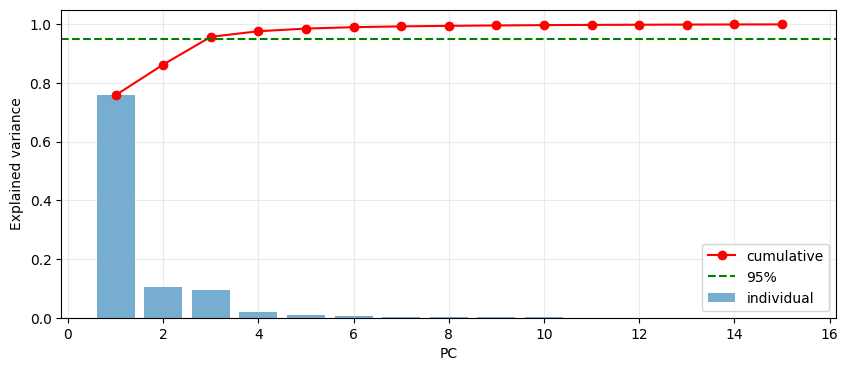

In [113]:
# -----------------------
# Scale + PCA
# -----------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

n_components = min(15, X_scaled.shape[1], X_scaled.shape[0])
if n_components < 2:
    raise RuntimeError("Not enough features/samples for PCA (need at least 2).")

pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 if cumulative_variance.max() >= 0.95 else n_components
print(f"PCA components: {n_components}, components for 95% var: {n_components_95}")
plt.figure(figsize=(10,4))
plt.bar(range(1, len(variance_ratio)+1), variance_ratio, alpha=0.6, label='individual')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'ro-', label='cumulative')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('PC'); plt.ylabel('Explained variance'); plt.legend(); plt.grid(alpha=0.25)
plt.show()

## 7) Chọn số cụm và phân cụm bằng KMeans


=== SELECTING K ===
k=2 | Silhouette=0.8126 | Calinski-Harabasz=122.94
k=3 | Silhouette=0.8058 | Calinski-Harabasz=106.70
k=4 | Silhouette=0.7739 | Calinski-Harabasz=126.35
k=5 | Silhouette=0.7391 | Calinski-Harabasz=117.13
k=6 | Silhouette=0.6259 | Calinski-Harabasz=117.58
k=7 | Silhouette=0.5998 | Calinski-Harabasz=121.59
k=8 | Silhouette=0.5946 | Calinski-Harabasz=136.38
k=9 | Silhouette=0.5116 | Calinski-Harabasz=150.80
Selected k (by silhouette): 2


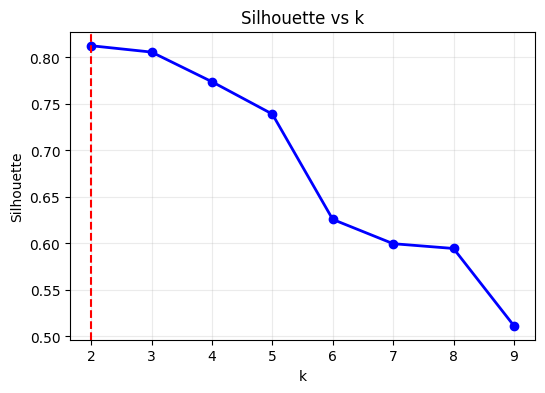


Clustering finished: 49 cryptos -> 2 clusters
Global silhouette: 0.8126


In [114]:
# -----------------------
# Choose k and cluster (KMeans)
# -----------------------
print("\n=== SELECTING K ===")
n_samples = X_scaled.shape[0]
max_k = min(15, max(2, n_samples // 5))  # heuristic: at least 5 samples per cluster

if max_k < 2:
    raise RuntimeError("Not enough samples to form clusters.")

k_range = range(2, max_k+1)
sil_scores = []
ch_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=15)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    sil_scores.append(sil)
    ch_scores.append(ch)
    print(f"k={k} | Silhouette={sil:.4f} | Calinski-Harabasz={ch:.2f}")

best_k = list(k_range)[int(np.argmax(sil_scores))]
print(f"Selected k (by silhouette): {best_k}")

plt.figure(figsize=(6,4))
plt.plot(list(k_range), sil_scores, 'bo-', linewidth=2)
plt.xlabel('k'); plt.ylabel('Silhouette'); plt.title('Silhouette vs k'); plt.grid(alpha=0.25)
plt.axvline(best_k, color='r', linestyle='--')
plt.show()

# final clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)
features_df['cluster'] = labels
global_silhouette = silhouette_score(X_scaled, labels)
features_df['global_silhouette'] = global_silhouette

print(f"\nClustering finished: {features_df.shape[0]} cryptos -> {best_k} clusters")
print(f"Global silhouette: {global_silhouette:.4f}")

## 8) Trực quan hóa và mô tả  các cụm

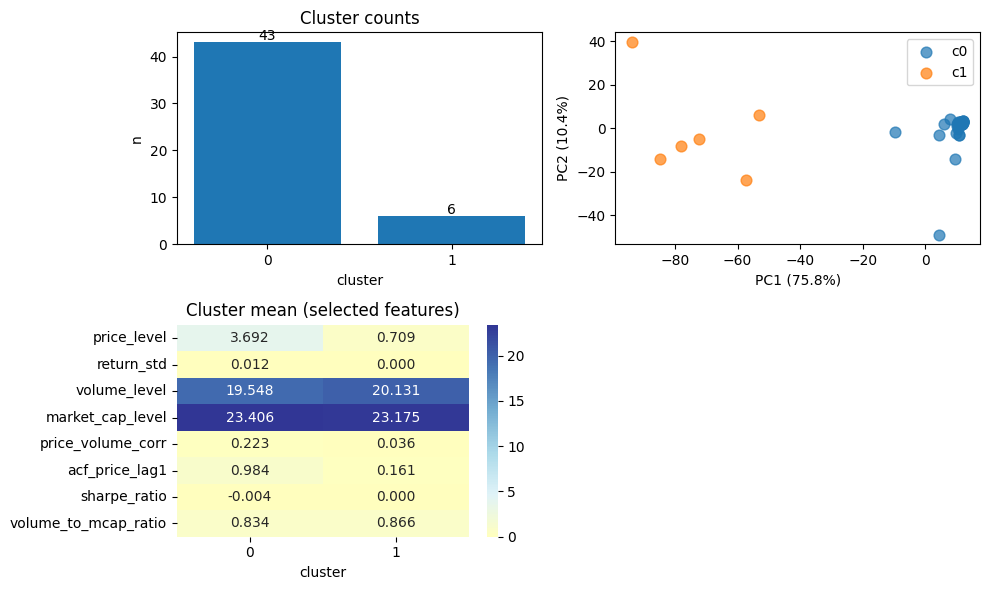


=== CLUSTER SUMMARIES ===

Cluster 0 - n=43
 Examples: aave (Aave...), AVAX (Avalanche...), BNB (BNB...), BTC (Bitcoin...), BCH (Bitcoin Cash...), bgb (Bitget Token...), ADA (Cardano...), LINK (Chainlink...)
 Traits: Autocorrelation / persistence
  • Avg price (exp): 39.14 USD
  • Return volatility: 0.0115
  • Price-Volume corr: 0.223

Cluster 1 - n=6
 Examples: bsc-usd (Binance Brid...), dai (Dai...), susde (Ethena Stake...), usdt (Tether...), usds (USDS...), usdt0 (USDT0...)
  • Avg price (exp): 1.03 USD
  • Return volatility: 0.0004
  • Price-Volume corr: 0.036


In [115]:
# -----------------------
# Visualization & cluster descriptions
# -----------------------
# cluster counts
cluster_counts = features_df['cluster'].value_counts().sort_index()
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.title('Cluster counts'); plt.xlabel('cluster'); plt.ylabel('n')
for i,c in enumerate(cluster_counts.values):
    plt.text(i, c+0.5, str(c), ha='center')

# PCA scatter (PC1 vs PC2) safe-check if at least 2 components
plt.subplot(2,2,2)
if X_pca.shape[1] >= 2:
    for cid in sorted(features_df['cluster'].unique()):
        mask = features_df['cluster'] == cid
        plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'c{cid}', alpha=0.7, s=60)
    plt.xlabel(f'PC1 ({variance_ratio[0]*100:.1f}%)'); plt.ylabel(f'PC2 ({variance_ratio[1]*100:.1f}%)')
    plt.legend()
else:
    plt.text(0.5,0.5,"PCA < 2 components", ha='center')

# heatmap of chosen features by cluster
plt.subplot(2,2,3)
important = ['price_level','return_std','volume_level','market_cap_level','price_volume_corr','acf_price_lag1','sharpe_ratio','volume_to_mcap_ratio']
avail = [f for f in important if f in feature_columns]
if avail:
    cluster_means = features_df.groupby('cluster')[avail].mean()
    sns.heatmap(cluster_means.T, annot=True, fmt='.3f', cmap='RdYlBu', center=0)
    plt.title('Cluster mean (selected features)')
else:
    plt.text(0.5,0.5,"No important features available", ha='center')

plt.tight_layout()
plt.show()

# print cluster summaries
global_stats = features_df[feature_columns].mean()
print("\n=== CLUSTER SUMMARIES ===")
for cid in sorted(features_df['cluster'].unique()):
    cdata = features_df[features_df['cluster'] == cid]
    sample = cdata[['symbol','name']].head(8).values.tolist()
    print(f"\nCluster {cid} - n={len(cdata)}")
    print(" Examples:", ', '.join([f"{s} ({n[:12]}...)" for s,n in sample]))
    cmean = cdata[feature_columns].mean()
    traits = []
    if 'market_cap_level' in cmean and cmean['market_cap_level'] > global_stats['market_cap_level'] * 1.2:
        traits.append("Large market cap")
    if 'return_std' in cmean and cmean['return_std'] > global_stats['return_std'] * 1.2:
        traits.append("High volatility")
    if 'acf_price_lag1' in cmean and cmean['acf_price_lag1'] > global_stats['acf_price_lag1'] + 0.1:
        traits.append("Autocorrelation / persistence")
    if 'price_volume_corr' in cmean and cmean['price_volume_corr'] > global_stats['price_volume_corr'] + 0.1:
        traits.append("Strong price-volume corr")
    if traits:
        print(" Traits:", '; '.join(traits))
    # some numeric stats
    if 'price_level' in cmean:
        try:
            print(f"  • Avg price (exp): {np.expm1(cmean['price_level']):,.2f} USD")
        except:
            pass
    if 'return_std' in cmean:
        print(f"  • Return volatility: {cmean['return_std']:.4f}")
    if 'price_volume_corr' in cmean:
        print(f"  • Price-Volume corr: {cmean['price_volume_corr']:.3f}")

In [116]:
# -----------------------
# Export
# -----------------------
output_df = features_df.reset_index()[['crypto_id','symbol','name','cluster'] + feature_columns]
output_df.to_csv('crypto_clustering_results.csv', index=False)
print("Saved results -> crypto_clustering_results.csv")

Saved results -> crypto_clustering_results.csv
